# Ensemble Learning

If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an *ensemble*; thus, this technique is called *ensemble learning*, and an ensemble learning algorithm is called an *ensemble method*.



## Voting Classifiers

Suppose you have trained a few classifiers, each one achieving about 80% accuracy.

A very simple way to create an even better classifier is to aggregate the predictions of each classifier: the class that gets the most votes is the ensemble’s prediction. This majority-vote classifier is called a *hard voting* classifier.

 This voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner, the ensemble can still be a strong learner, provided there are a sufficient number of weak learners in the ensemble, and they are sufficiently diverse.

### Voting Classifier wtih scikit-learn: `VotingClassifier`

Let's load and split the "moons" dataset into a training and test set, then add a voting classifier composed of three diverse classifiers: in this case, logistic regression, random forest and support vector classifier.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Let's check the accuracy of each classifier on the test set:

In [20]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


To perfrom a hard vote, let's call the `predict()` method:

In [21]:
voting_clf.predict(X_test[:1])

array([1])

We can check how the classifier predicted:

In [22]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

Now let's look at the performance of the voting classifier on the test set:

In [23]:
voting_clf.score(X_test, y_test)

0.912

If all classifiers are able to estimate class probabilities (i.e., if they all have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called *soft voting*. It often achieves higher performance than hard voting because it gives more weight to highly confident votes.

In [24]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Bagging and Pasting

Another approach is to use the same training algorithm for every predictor but train them on different random subsets of the training set. When sampling is performed with replacement this method is called *bagging* (short for bootstrap aggregating). When sampling is performed without replacement, it is called *pasting*.

Both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the statistical mode for classification (i.e., the most frequent prediction, just like with a hard voting classifier), or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance.

### Bagging and Pasting in Scikit-Learn

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

See how a single decision tree performs against a bagging ensemble of 500 trees:

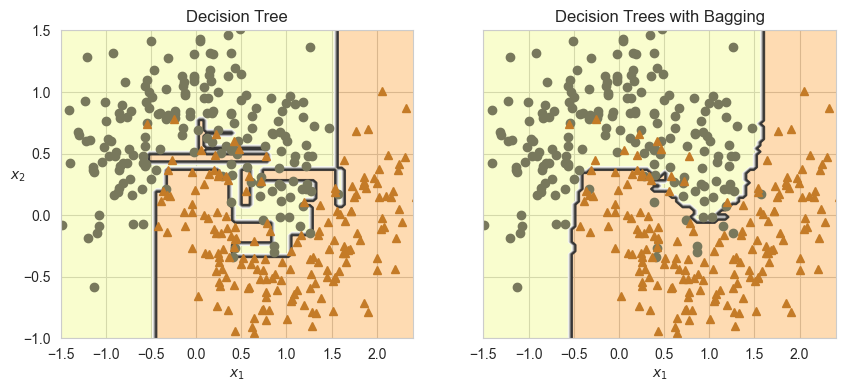

In [26]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

#### Out-of-Bag Evaluation

With bagging, some training instances may be sampled several times for any given predictor, while others may not be sampled at all. By default, a `BaggingClassifier` samples $m$ training instances with replacement (`bootstrap=True`), where $m$ is the size of the training set. With this process, about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called *out-of-bag (OOB)* instances. Note that they are not the same 37% for all predictors.

A bagging ensemble can be evaluated using OOB instances, without the need for a separate validation set: if there are enough estimators, then each instance in the training set will likely be an OOB instance of several estimators, so these estimators can be used to make a fair ensemble prediction for that instance. Once you have a prediction for each instance, you can compute the ensemble’s prediction metrics.

In Scikit-Learn, you can set `oob_score=True` when creating a `BaggingClassifier` to request an automatic OOB evaluation after training.

In [27]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

Let's check the first three instances and their accuracy score:

In [30]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

The OOB evaluation was a bit too pessimistic.

The OOB decision function for each training instance is also available through the `oob_decision_function_` attribute. Since the base estimator has a `predict_proba()` method, the decision function returns the class probabilities for each training instance. For example, the OOB evaluation estimates that the first training instance has a 67.6% probability of belonging to the positive class and a 32.4% probability of belonging to the negative class:

In [31]:
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

#### Random Patches and Random Subspaces

The `BaggingClassifier` class supports sampling the features as well. Sampling is controlled by two hyperparameters: `max_features` and `bootstrap_features`. They work the same way as `max_samples` and `bootstrap`, but for feature sampling instead of instance sampling.

Thus, each predictor will be trained on a random subset of the input features.

This technique is particularly useful when you are dealing with high-dimensional inputs (such as images), as it can considerably speed up training. Sampling both training instances and features is called the *random patches method*. Keeping all training instances (by setting `bootstrap=False` and `max_samples=1.0`) but sampling features (by setting `bootstrap_features` to `True` and/or `max_features` to a value smaller than 1.0) is called the *random subspaces method*.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

# Random Forests

As an example of an ensemble method, you can train a group of decision tree classifiers, each on a different random subset of the training set. You can then obtain the predictions of all the individual trees, and the class that gets the most votes is the ensemble’s prediction. Such an ensemble of decision trees is called a *random forest*.

Although random forests don’t offer the same level of interpretability as decision trees, a big advantage of random forests is that we don’t have to worry so much about choosing good hyperparameter values. We typically don’t need to prune the random forest since the ensemble model is quite robust to noise from averaging the predictions among the individual decision trees. The only parameter that we need to care about in practice is the number of trees, k, that we choose for the random forest. Typically, the larger the number of trees, the better the performance of the random forest classifier at the expense of an increased computational cost.

### Feature Importance

Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduces impurity on average, across all trees in the forest. More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it (see the `feature_importances_` attribute).

Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1.

### Examples - Random Forest classification

#### Example 1 - Random Forests classification

In [32]:
df = pd.read_csv("./data/penguins.csv")

In [33]:
df = df.dropna()
df.drop(['Unnamed: 0', 'year'],axis=1,inplace=True)


In [34]:
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male


In [35]:
X = pd.get_dummies(df.drop('species',axis=1),drop_first=True)
y = df['species']

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
model = RandomForestClassifier(n_estimators=10,random_state=101)

In [40]:
model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=101)

In [41]:
preds = model.predict(X_test)

In [42]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,ConfusionMatrixDisplay

In [43]:
confusion_matrix(y_test,preds)

array([[40,  0,  0],
       [ 0, 19,  0],
       [ 0,  0, 41]])

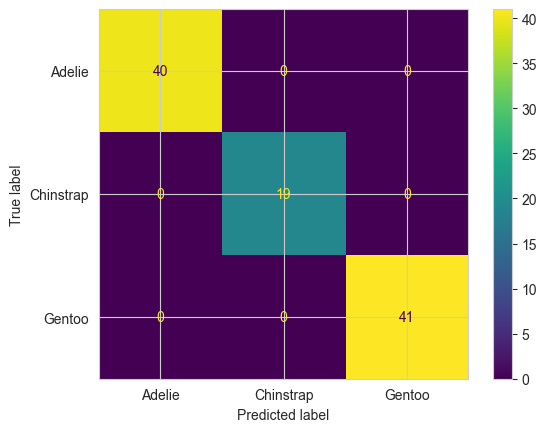

In [44]:
ConfusionMatrixDisplay(confusion_matrix(y_test,preds),display_labels=model.classes_).plot()

In [45]:
model.feature_importances_

array([0.36432091, 0.09553661, 0.20559243, 0.19993182, 0.11150935,
       0.01438063, 0.00872825])

In [46]:
test_error = []

for n in range(1,38):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=n)
    model.fit(X_train,y_train)
    test_preds = model.predict(X_test)
    test_error.append(1-accuracy_score(test_preds,y_test))

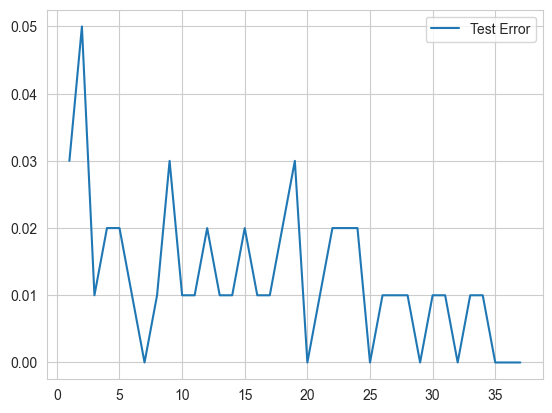

In [47]:
plt.plot(range(1,38),test_error,label='Test Error')
plt.legend()

#### Example 2 - Random Forests classification

In [48]:
df = pd.read_csv("./data/data_banknote_authentication.csv")

In [49]:
df.head()

,Variance_Wavelet,Skewness_Wavelet,Curtosis_Wavelet,Image_Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


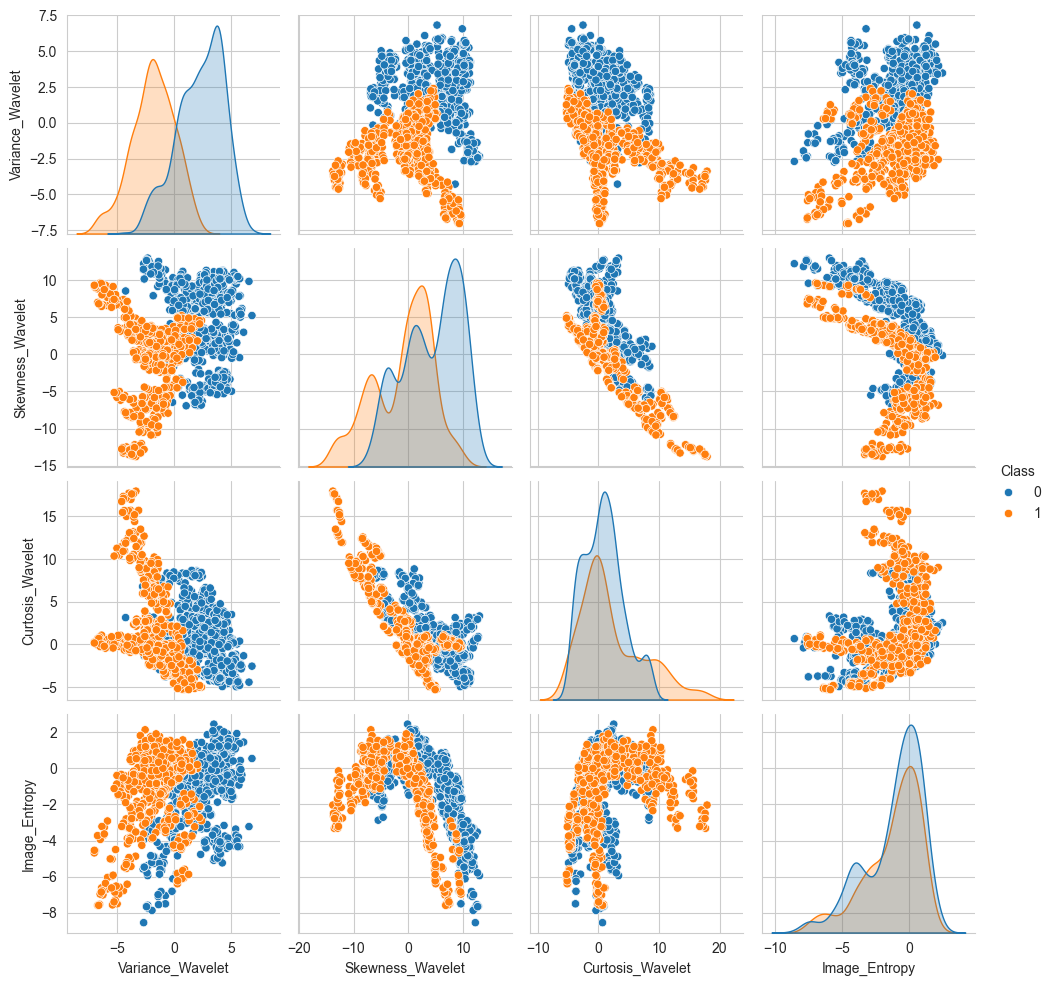

In [50]:
sns.pairplot(df,hue='Class')

In [51]:
X = df.drop("Class",axis=1)
y = df['Class']

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
param_grid = [
    {'n_estimators': [64, 100, 128, 200], 'max_features': [2, 3, 4], 'bootstrap': [True], 'oob_score': [True]},
    {'n_estimators': [64, 100, 128, 200], 'max_features': [2, 3, 4], 'bootstrap': [False], 'oob_score': [False]}
]

In [56]:
rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid)

In [57]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'bootstrap': [True], 'max_features': [2, 3, 4],
                          'n_estimators': [64, 100, 128, 200],
                          'oob_score': [True]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [64, 100, 128, 200],
                          'oob_score': [False]}])

In [58]:
grid.best_params_

{'bootstrap': True, 'max_features': 2, 'n_estimators': 64, 'oob_score': True}

In [59]:
predictions = grid.predict(X_test)

In [60]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       124
           1       0.98      1.00      0.99        82

    accuracy                           0.99       206
   macro avg       0.99      0.99      0.99       206
weighted avg       0.99      0.99      0.99       206



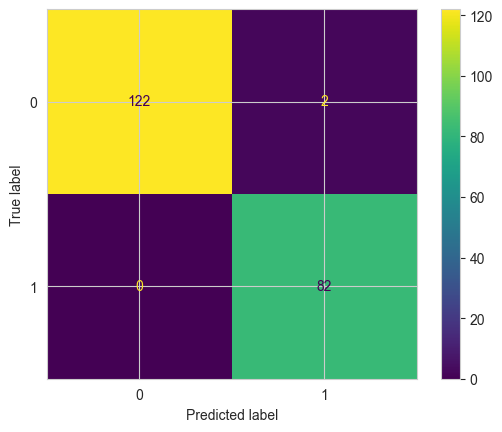

In [61]:
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test)

In [62]:
grid.best_estimator_.oob_score

True

In [63]:
grid.best_estimator_.oob_score_

0.9922813036020584

In [64]:
from sklearn.metrics import accuracy_score

In [65]:
errors = []
misclassifications = []

for n in range(1,64):
    rfc = RandomForestClassifier( n_estimators=n,bootstrap=True,max_features= 2)
    rfc.fit(X_train,y_train)
    preds = rfc.predict(X_test)
    err = 1 - accuracy_score(preds,y_test)
    n_missed = np.sum(preds != y_test) # watch the video to understand this line!!
    errors.append(err)
    misclassifications.append(n_missed)

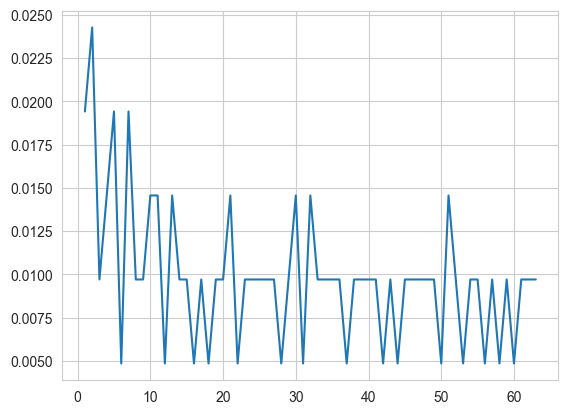

In [66]:
plt.plot(range(1,64),errors,label='Error Rate')

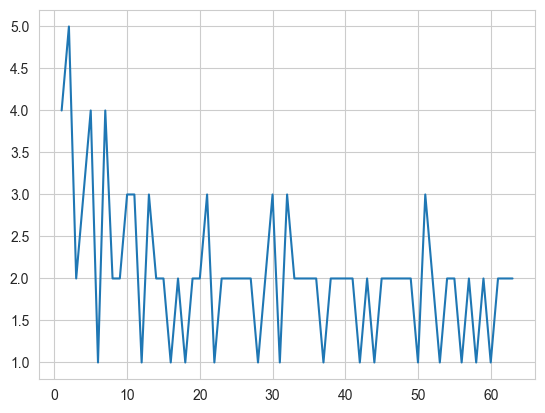

In [67]:
plt.plot(range(1,64),misclassifications,label='Misclassifications')

### Examples - Random Forest regression

#### Example 1 - Random Forests regression

In [68]:
df = pd.read_csv("./data/rock_density_xray.csv")

In [69]:
df.head()

,Rebound Signal Strength nHz,Rock Density kg/m3
0,72.945124,2.456548
1,14.229877,2.601719
2,36.597334,1.967004
3,9.578899,2.300439
4,21.765897,2.452374


In [70]:
df.columns=['Signal',"Density"]

<Axes: xlabel='Signal', ylabel='Density'>

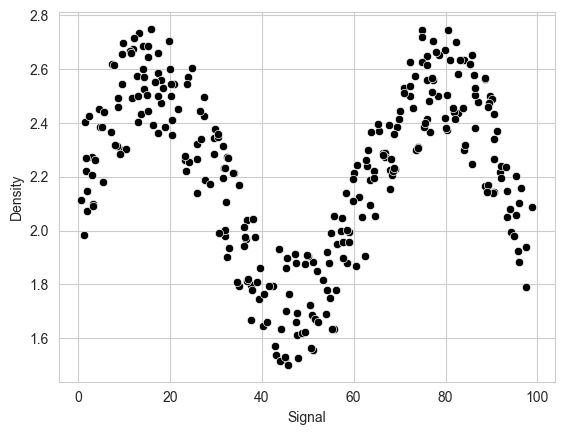

In [71]:
sns.scatterplot(x='Signal',y='Density',data=df, color='k')

In [72]:
X = df['Signal'].values.reshape(-1, 1)
y = df['Density']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [73]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)

LinearRegression()

In [74]:
lm_preds = linear_model.predict(X_test)

In [75]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test,lm_preds))

np.float64(0.2570051996584629)

In [76]:
signal_range = np.arange(0,100)

In [77]:
lm_output = linear_model.predict(signal_range.reshape(-1,1))

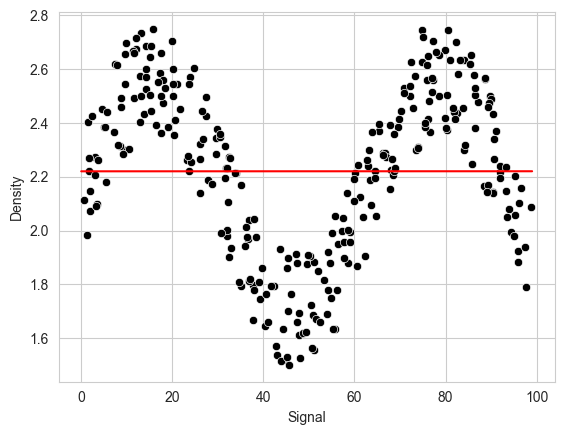

In [78]:
sns.scatterplot(x='Signal',y='Density',data=df, color='k')
plt.plot(signal_range,lm_output,'r')

In [79]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [80]:
def run_model(model,X_train,y_train,X_test,y_test):

    # Fit Model
    model.fit(X_train,y_train)

    # Get Metrics

    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print(f'RMSE : {rmse}')

    # Plot results
    signal_range = np.arange(0,100)
    output = model.predict(signal_range.reshape(-1,1))

    sns.scatterplot(x='Signal',y='Density',data=df, color='k')
    plt.plot(signal_range,output)
    plt.show()

RMSE : 0.2570051996584629


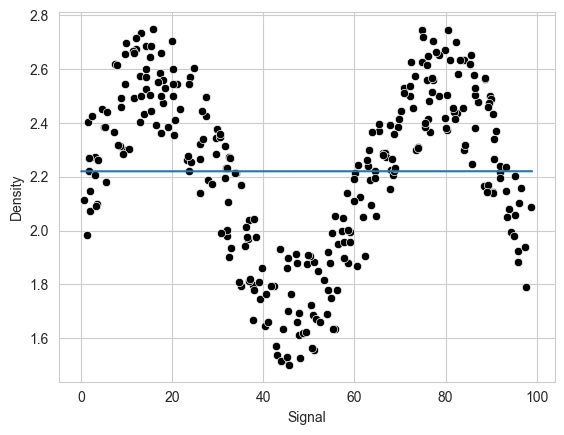

In [81]:
run_model(model,X_train,y_train,X_test,y_test)

In [82]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(PolynomialFeatures(2),LinearRegression())

RMSE : 0.2817309563725596


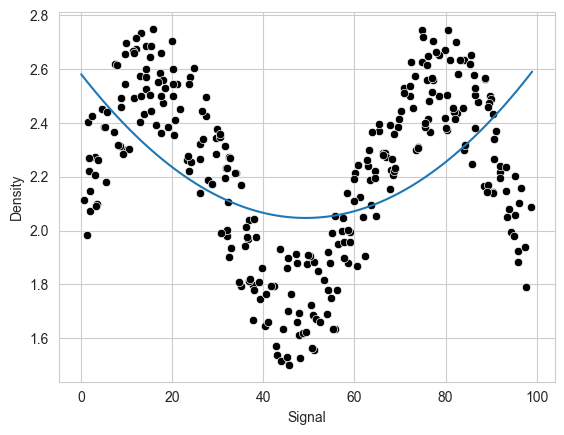

In [83]:
run_model(pipe,X_train,y_train,X_test,y_test)

RMSE : 0.16269005292854596


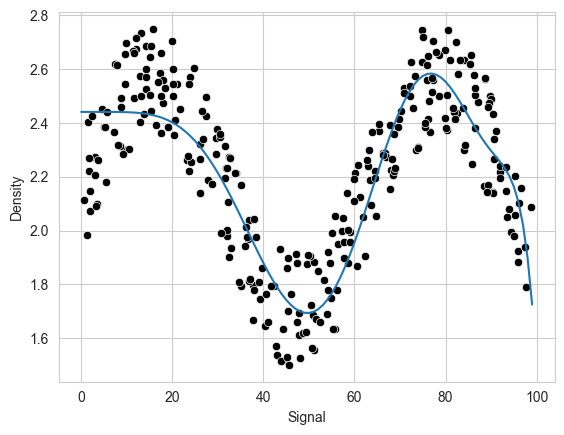

In [84]:
pipe = make_pipeline(PolynomialFeatures(10),LinearRegression())
run_model(pipe,X_train,y_train,X_test,y_test)

In [85]:
from sklearn.neighbors import KNeighborsRegressor

RMSE : 0.1523487028635337


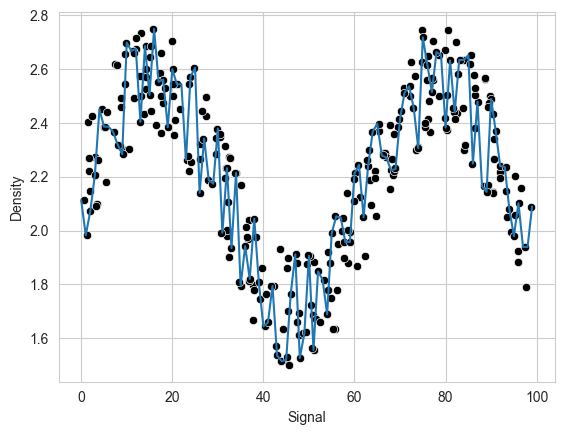

RMSE : 0.13730685016923647


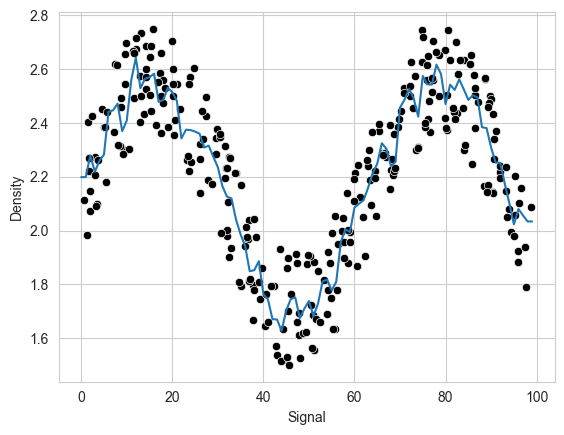

RMSE : 0.13277855732740926


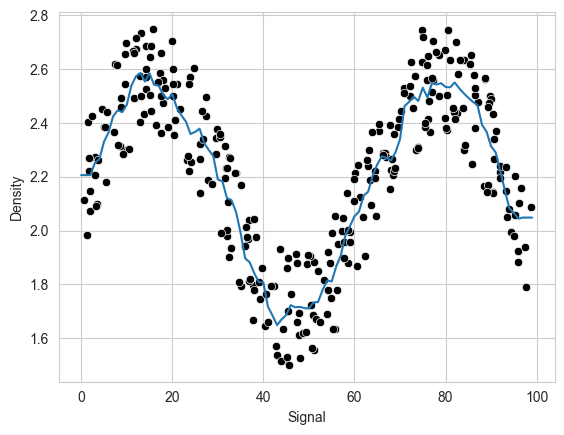

In [86]:
preds = {}
k_values = [1,5,10]
for n in k_values:


    model = KNeighborsRegressor(n_neighbors=n)
    run_model(model,X_train,y_train,X_test,y_test)

RMSE : 0.1523487028635337


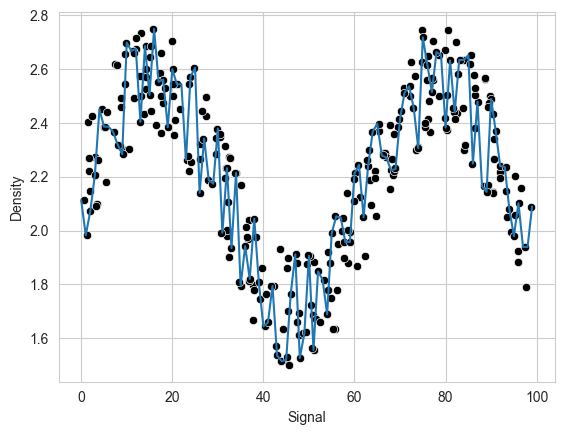

In [87]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()

run_model(model,X_train,y_train,X_test,y_test)

In [88]:
model.get_n_leaves()

np.int64(270)

RMSE : 0.12646999302046696


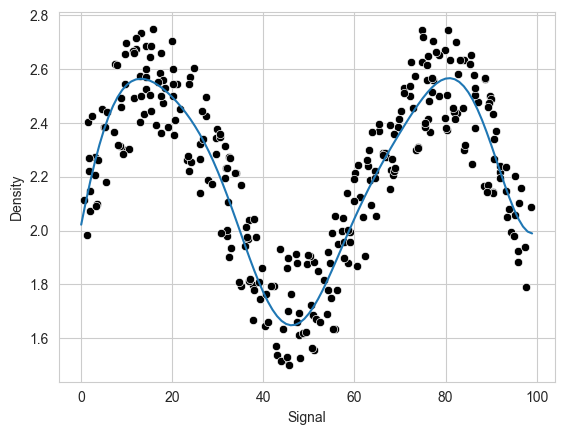

In [89]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.01,0.1,1,5,10,100,1000],'gamma':['auto','scale']}
svr = SVR()
grid = GridSearchCV(svr,param_grid)
run_model(grid,X_train,y_train,X_test,y_test)

In [90]:
grid.best_estimator_

SVR(C=1000)

In [91]:
from sklearn.ensemble import RandomForestRegressor

RMSE : 0.12955601343537265


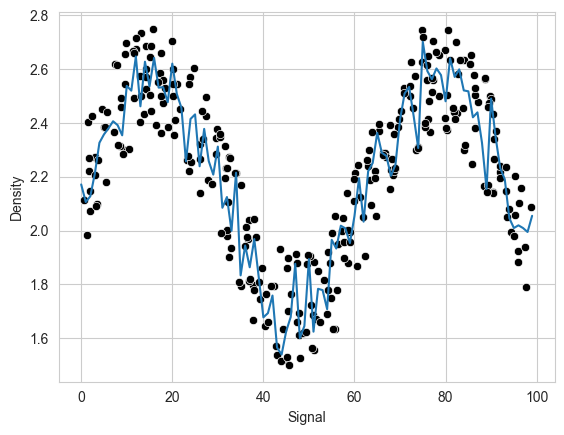

RMSE : 0.1354981854012535


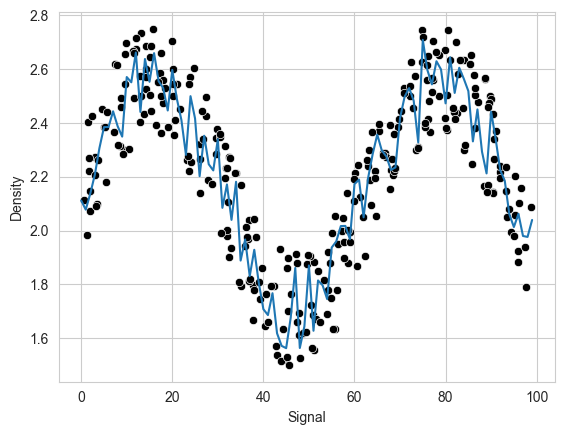

RMSE : 0.1330941200484315


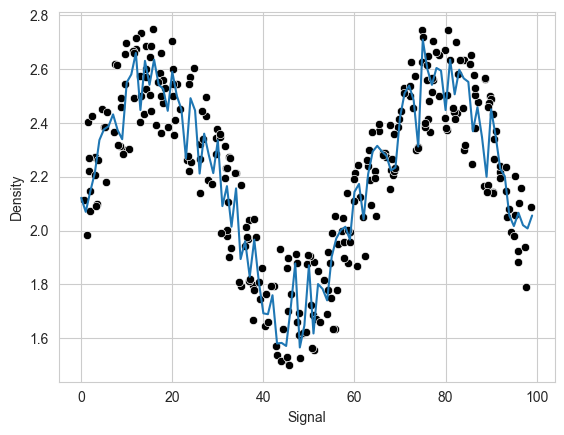

In [92]:
trees = [10,50,100]
for n in trees:

    model = RandomForestRegressor(n_estimators=n)

    run_model(model,X_train,y_train,X_test,y_test)

In [93]:
from sklearn.ensemble import GradientBoostingRegressor

RMSE : 0.13294148649584667


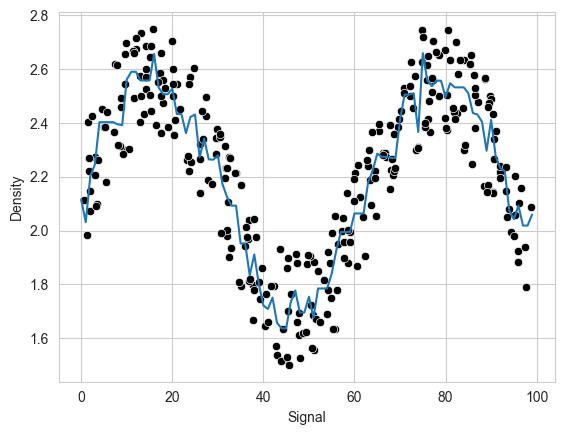

In [94]:
model = GradientBoostingRegressor()
run_model(model,X_train,y_train,X_test,y_test)

RMSE : 0.13504026229843766


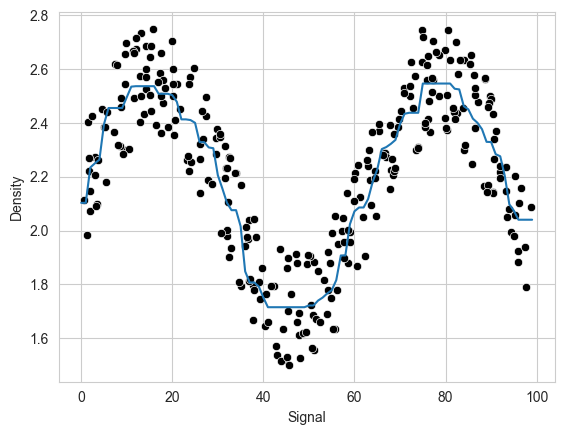

In [95]:
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor()
run_model(model,X_train,y_train,X_test,y_test)